In [7]:
# ===== PART 1: DATA PREPARATION =====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Install library for binary Excel files
!pip install pyxlsb

# Load data
df = pd.read_excel('retail_price.xlsb', engine='pyxlsb')

# Convert date - let pandas auto-detect the format
df['month_year'] = pd.to_datetime(df['month_year'])  # ← FIXED THIS LINE

# Feature engineering
df['price_vs_comp1'] = df['unit_price'] / df['ps1']
df['price_vs_comp2'] = df['unit_price'] / df['ps2']
df['price_vs_comp3'] = df['unit_price'] / df['ps3']
df['avg_competitor_price'] = (df['ps1'] + df['ps2'] + df['ps3']) / 3
df['price_difference'] = df['unit_price'] - df['avg_competitor_price']
df['is_cheapest'] = (df['unit_price'] < df['ps1']) & (df['unit_price'] < df['ps2']) & (df['unit_price'] < df['ps3'])
df['revenue'] = df['qty'] * df['unit_price']
df['profit_margin'] = df['unit_price'] - df['freight_price']

print("Data prepared successfully!")
print(f"Dataset shape: {df.shape}")

Data prepared successfully!
Dataset shape: (676, 38)


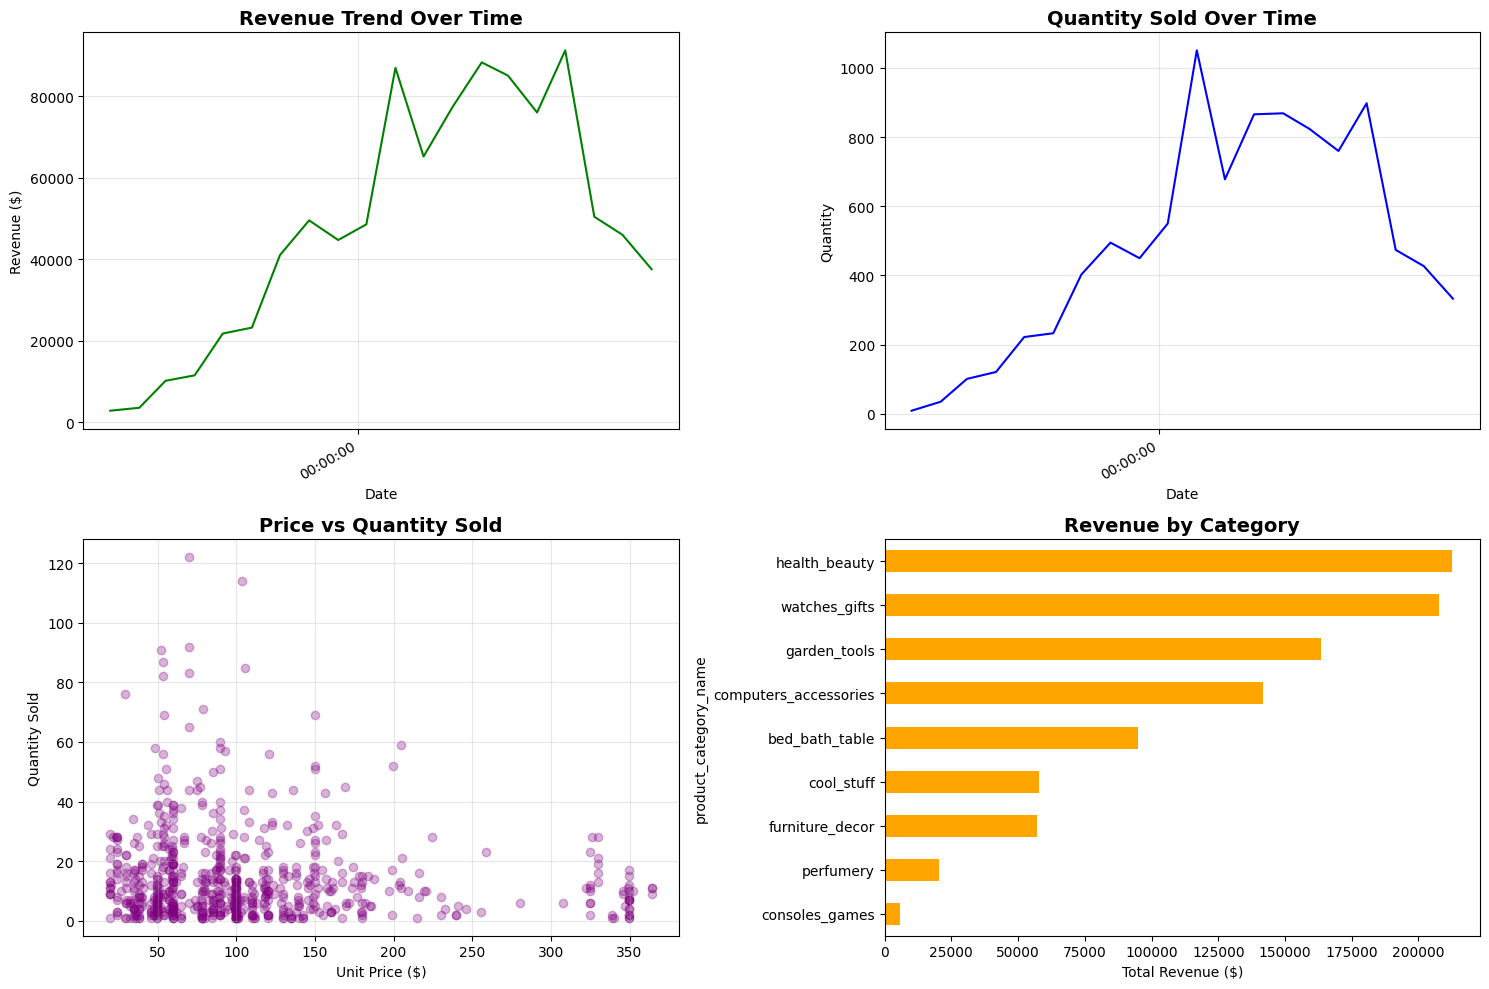

📊 Exploratory Data Analysis Complete!

📈 Total Revenue: $961,421.03
📦 Total Units Sold: 9,799
🏷️ Number of Products: 52
📂 Number of Categories: 9

💰 Average Unit Price: $106.50
💰 Price Range: $19.90 - $364.00


In [8]:
# ===== PART 2: EXPLORATORY DATA ANALYSIS =====

# 1. Sales trends over time
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Total revenue over time
df.groupby('month_year')['revenue'].sum().plot(ax=axes[0,0], color='green')
axes[0,0].set_title('Revenue Trend Over Time', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Date')
axes[0,0].set_ylabel('Revenue ($)')
axes[0,0].grid(True, alpha=0.3)

# Quantity sold over time
df.groupby('month_year')['qty'].sum().plot(ax=axes[0,1], color='blue')
axes[0,1].set_title('Quantity Sold Over Time', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Date')
axes[0,1].set_ylabel('Quantity')
axes[0,1].grid(True, alpha=0.3)

# Price vs Quantity relationship
axes[1,0].scatter(df['unit_price'], df['qty'], alpha=0.3, color='purple')
axes[1,0].set_title('Price vs Quantity Sold', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Unit Price ($)')
axes[1,0].set_ylabel('Quantity Sold')
axes[1,0].grid(True, alpha=0.3)

# Category performance
category_sales = df.groupby('product_category_name')['revenue'].sum().sort_values()
category_sales.plot(kind='barh', ax=axes[1,1], color='orange')
axes[1,1].set_title('Revenue by Category', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Total Revenue ($)')

plt.tight_layout()
plt.show()

print("📊 Exploratory Data Analysis Complete!")
print(f"\n📈 Total Revenue: ${df['revenue'].sum():,.2f}")
print(f"📦 Total Units Sold: {df['qty'].sum():,}")
print(f"🏷️ Number of Products: {df['product_id'].nunique()}")
print(f"📂 Number of Categories: {df['product_category_name'].nunique()}")
print(f"\n💰 Average Unit Price: ${df['unit_price'].mean():.2f}")
print(f"💰 Price Range: ${df['unit_price'].min():.2f} - ${df['unit_price'].max():.2f}")

PRICE ELASTICITY ANALYSIS
Average Price Elasticity: -1.43
Median Price Elasticity: -2.00


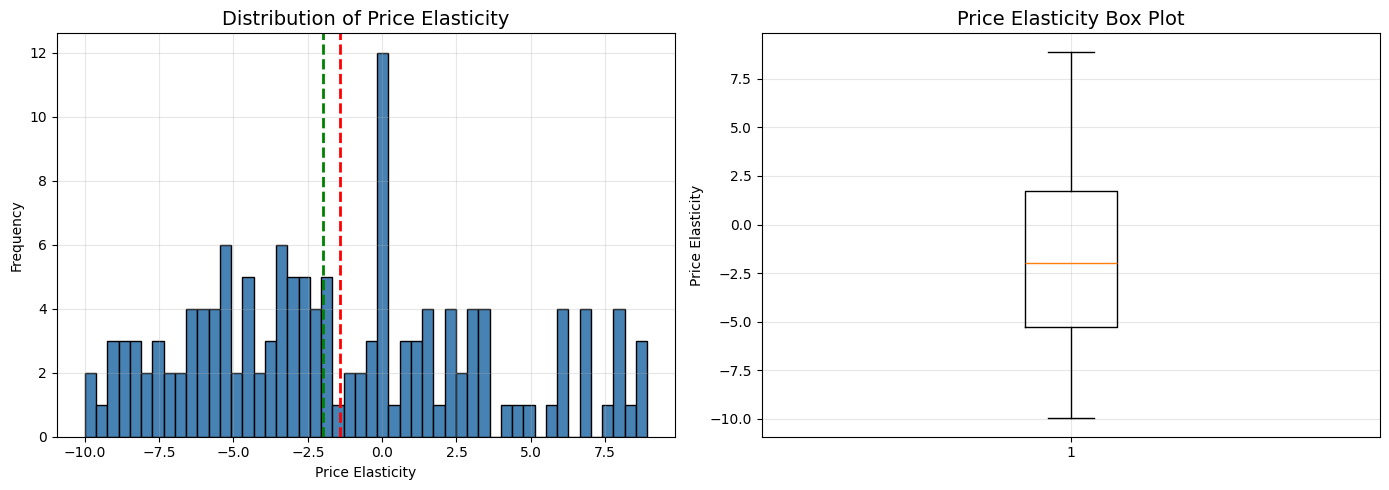

In [9]:
# ===== PART 3: PRICE ELASTICITY ANALYSIS =====

# Calculate price elasticity
df_sorted = df.sort_values(['product_id', 'month_year'])
df_sorted['price_change_pct'] = df_sorted.groupby('product_id')['unit_price'].pct_change()
df_sorted['qty_change_pct'] = df_sorted.groupby('product_id')['qty'].pct_change()

# Remove infinite and NaN values
elasticity_df = df_sorted[['price_change_pct', 'qty_change_pct']].replace([np.inf, -np.inf], np.nan).dropna()
elasticity_df['price_elasticity'] = elasticity_df['qty_change_pct'] / elasticity_df['price_change_pct']

# Remove outliers
elasticity_df = elasticity_df[(elasticity_df['price_elasticity'] > -10) & (elasticity_df['price_elasticity'] < 10)]

mean_val = elasticity_df['price_elasticity'].mean()
median_val = elasticity_df['price_elasticity'].median()

print("=" * 60)
print("PRICE ELASTICITY ANALYSIS")
print("=" * 60)
print(f"Average Price Elasticity: {mean_val:.2f}")
print(f"Median Price Elasticity: {median_val:.2f}")
print("=" * 60)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(elasticity_df['price_elasticity'], bins=50, edgecolor='black', color='steelblue')
axes[0].axvline(mean_val, color='red', linestyle='--', linewidth=2)
axes[0].axvline(median_val, color='green', linestyle='--', linewidth=2)
axes[0].set_title('Distribution of Price Elasticity', fontsize=14)
axes[0].set_xlabel('Price Elasticity')
axes[0].set_ylabel('Frequency')
axes[0].grid(True, alpha=0.3)

axes[1].boxplot(elasticity_df['price_elasticity'], vert=True)
axes[1].set_title('Price Elasticity Box Plot', fontsize=14)
axes[1].set_ylabel('Price Elasticity')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

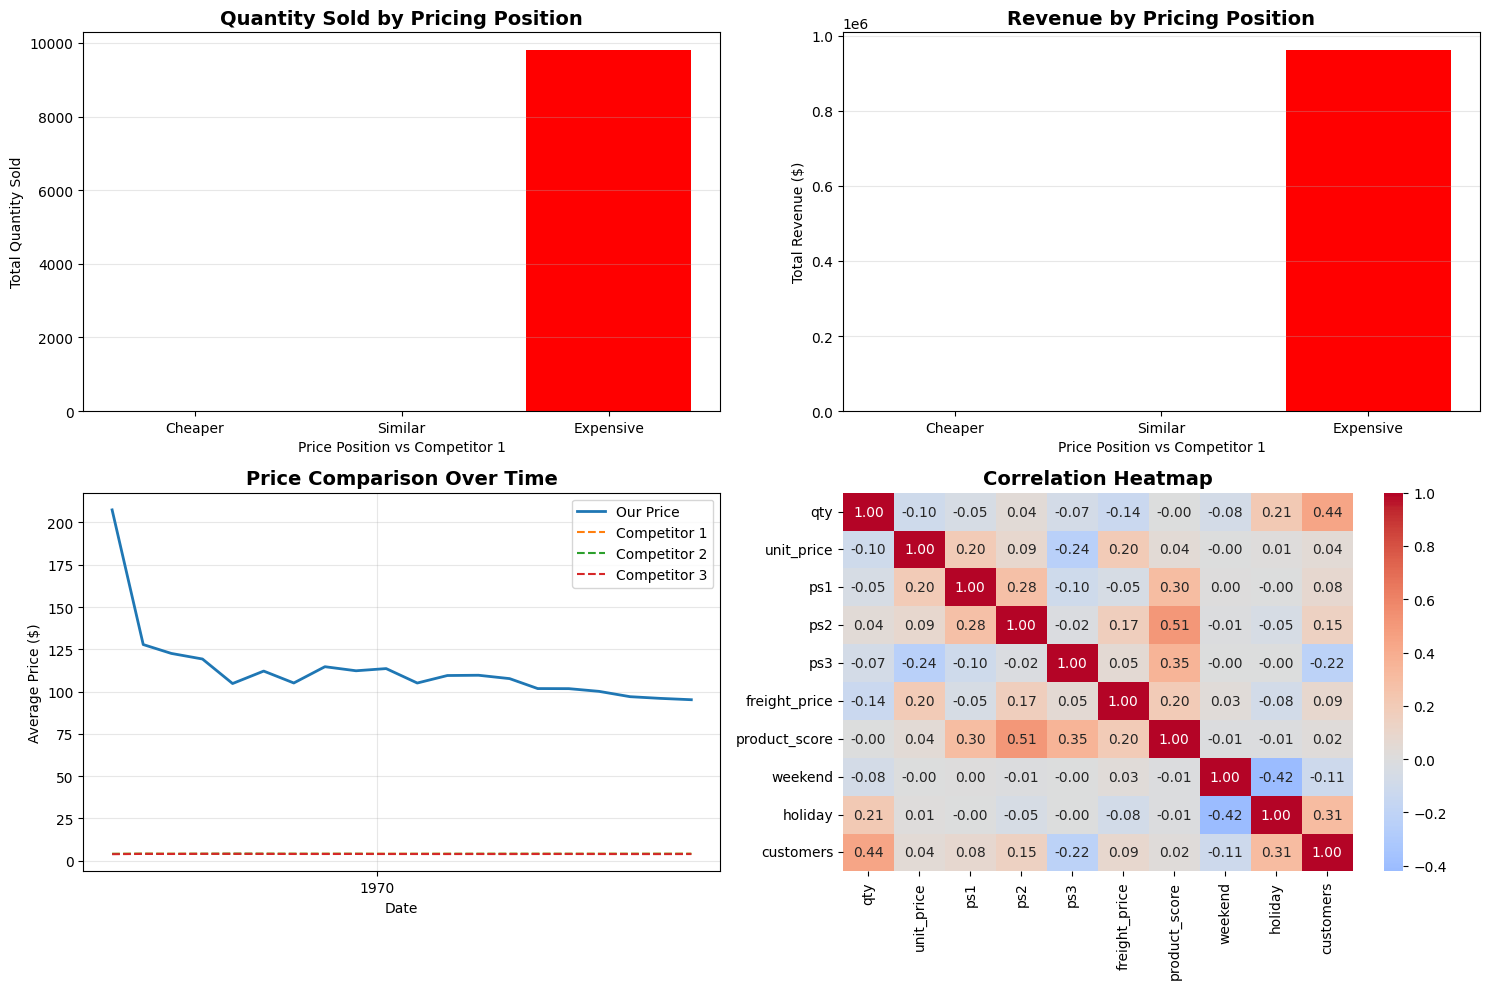

COMPETITOR ANALYSIS INSIGHTS

Sales by Pricing Position:
pricing_position
Cheaper         0
Similar         0
Expensive    9799
Name: qty, dtype: int64

Revenue by Pricing Position:
pricing_position
Cheaper           0.000000
Similar           0.000000
Expensive    961421.026155
Name: revenue, dtype: float64

Average Prices:
Our Average Price: $106.50
Competitor 1 Avg: $4.16
Competitor 2 Avg: $4.12
Competitor 3 Avg: $4.00


In [10]:
# ===== PART 4: COMPETITOR PRICE ANALYSIS =====

# How does our pricing compare to competitors?
df['pricing_position'] = pd.cut(df['price_vs_comp1'],
                                  bins=[0, 0.9, 1.1, np.inf],
                                  labels=['Cheaper', 'Similar', 'Expensive'])

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Sales by pricing position
pricing_qty = df.groupby('pricing_position')['qty'].sum()
axes[0,0].bar(pricing_qty.index, pricing_qty.values, color=['green', 'orange', 'red'])
axes[0,0].set_title('Quantity Sold by Pricing Position', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Price Position vs Competitor 1')
axes[0,0].set_ylabel('Total Quantity Sold')
axes[0,0].grid(True, alpha=0.3, axis='y')

# Revenue by pricing position
pricing_rev = df.groupby('pricing_position')['revenue'].sum()
axes[0,1].bar(pricing_rev.index, pricing_rev.values, color=['green', 'orange', 'red'])
axes[0,1].set_title('Revenue by Pricing Position', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Price Position vs Competitor 1')
axes[0,1].set_ylabel('Total Revenue ($)')
axes[0,1].grid(True, alpha=0.3, axis='y')

# Price comparison over time
price_comparison = df.groupby('month_year')[['unit_price', 'ps1', 'ps2', 'ps3']].mean()
axes[1,0].plot(price_comparison.index, price_comparison['unit_price'], label='Our Price', linewidth=2)
axes[1,0].plot(price_comparison.index, price_comparison['ps1'], label='Competitor 1', linestyle='--')
axes[1,0].plot(price_comparison.index, price_comparison['ps2'], label='Competitor 2', linestyle='--')
axes[1,0].plot(price_comparison.index, price_comparison['ps3'], label='Competitor 3', linestyle='--')
axes[1,0].set_title('Price Comparison Over Time', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Date')
axes[1,0].set_ylabel('Average Price ($)')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Correlation heatmap
correlation_cols = ['qty', 'unit_price', 'ps1', 'ps2', 'ps3', 'freight_price',
                   'product_score', 'weekend', 'holiday', 'customers']
sns.heatmap(df[correlation_cols].corr(), annot=True, cmap='coolwarm', center=0, ax=axes[1,1], fmt='.2f')
axes[1,1].set_title('Correlation Heatmap', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Print insights
print("=" * 60)
print("COMPETITOR ANALYSIS INSIGHTS")
print("=" * 60)
print("\nSales by Pricing Position:")
print(df.groupby('pricing_position')['qty'].sum())
print("\nRevenue by Pricing Position:")
print(df.groupby('pricing_position')['revenue'].sum())
print("\nAverage Prices:")
print(f"Our Average Price: ${df['unit_price'].mean():.2f}")
print(f"Competitor 1 Avg: ${df['ps1'].mean():.2f}")
print(f"Competitor 2 Avg: ${df['ps2'].mean():.2f}")
print(f"Competitor 3 Avg: ${df['ps3'].mean():.2f}")
print("=" * 60)

TRAINING DEMAND FORECASTING MODEL
Training samples: 540
Testing samples: 136

Training Random Forest model...

MODEL PERFORMANCE
Mean Absolute Error (MAE): 8.82 units
Root Mean Squared Error (RMSE): 12.80 units
R² Score: 0.395

Interpretation:
- On average, predictions are off by 8.82 units
- The model explains 39.5% of the variance in demand


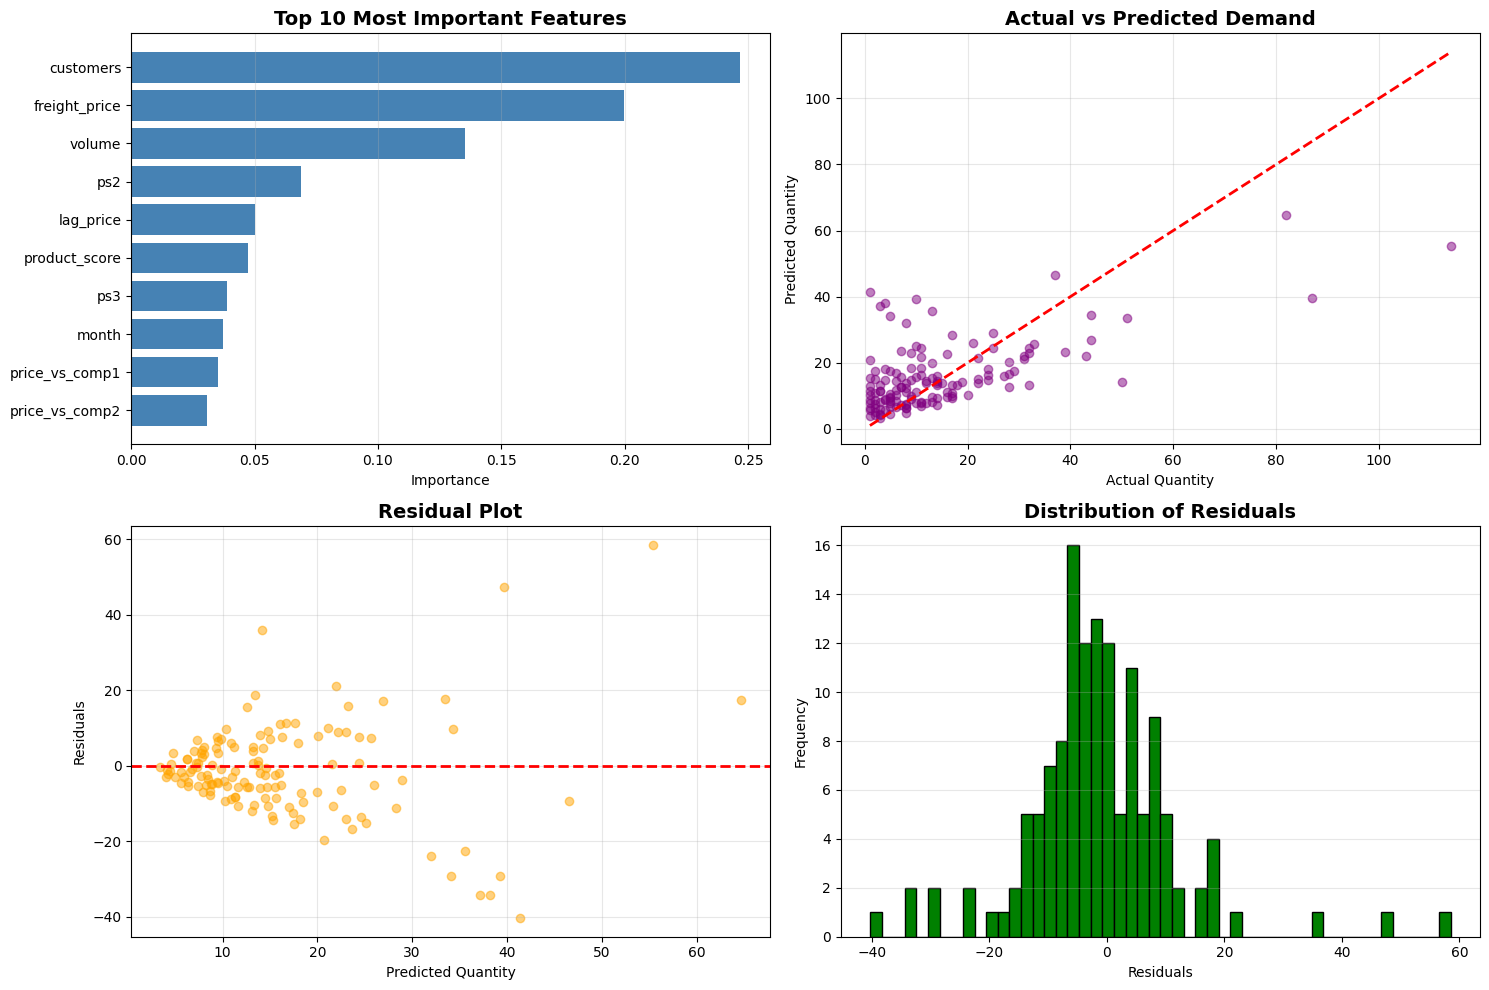


Top 10 Most Important Features:
       feature  importance
     customers    0.246571
 freight_price    0.199524
        volume    0.135436
           ps2    0.068839
     lag_price    0.050028
 product_score    0.047309
           ps3    0.038775
         month    0.037068
price_vs_comp1    0.035077
price_vs_comp2    0.030689


In [11]:
# ===== PART 5: DEMAND FORECASTING MODEL =====

# Prepare features
feature_cols = ['unit_price', 'freight_price', 'product_score', 'customers',
               'weekend', 'holiday', 'month', 'year', 'volume',
               'ps1', 'ps2', 'ps3', 'lag_price',
               'price_vs_comp1', 'price_vs_comp2', 'avg_competitor_price',
               'price_difference', 'is_cheapest']

X = df[feature_cols].fillna(0)
y = df['qty']

# Convert boolean to int
X['is_cheapest'] = X['is_cheapest'].astype(int)

# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("=" * 60)
print("TRAINING DEMAND FORECASTING MODEL")
print("=" * 60)
print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")
print("\nTraining Random Forest model...")

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n" + "=" * 60)
print("MODEL PERFORMANCE")
print("=" * 60)
print(f"Mean Absolute Error (MAE): {mae:.2f} units")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} units")
print(f"R² Score: {r2:.3f}")
print(f"\nInterpretation:")
print(f"- On average, predictions are off by {mae:.2f} units")
print(f"- The model explains {r2*100:.1f}% of the variance in demand")
print("=" * 60)

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Feature importance
top_features = feature_importance.head(10)
axes[0,0].barh(top_features['feature'], top_features['importance'], color='steelblue')
axes[0,0].set_xlabel('Importance')
axes[0,0].set_title('Top 10 Most Important Features', fontsize=14, fontweight='bold')
axes[0,0].invert_yaxis()
axes[0,0].grid(True, alpha=0.3, axis='x')

# Actual vs Predicted
axes[0,1].scatter(y_test, y_pred, alpha=0.5, color='purple')
axes[0,1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
axes[0,1].set_xlabel('Actual Quantity')
axes[0,1].set_ylabel('Predicted Quantity')
axes[0,1].set_title('Actual vs Predicted Demand', fontsize=14, fontweight='bold')
axes[0,1].grid(True, alpha=0.3)

# Residuals
residuals = y_test - y_pred
axes[1,0].scatter(y_pred, residuals, alpha=0.5, color='orange')
axes[1,0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1,0].set_xlabel('Predicted Quantity')
axes[1,0].set_ylabel('Residuals')
axes[1,0].set_title('Residual Plot', fontsize=14, fontweight='bold')
axes[1,0].grid(True, alpha=0.3)

# Residuals distribution
axes[1,1].hist(residuals, bins=50, edgecolor='black', color='green')
axes[1,1].set_xlabel('Residuals')
axes[1,1].set_ylabel('Frequency')
axes[1,1].set_title('Distribution of Residuals', fontsize=14, fontweight='bold')
axes[1,1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

TRAINING ENHANCED MODELS

1. Training Enhanced Random Forest...
   MAE: 6.92
   RMSE: 10.54
   R² Score: 0.590

2. Training Gradient Boosting Model...
   MAE: 7.12
   RMSE: 11.04
   R² Score: 0.550

BEST MODEL: Random Forest
R² Score: 0.590 (59.0% variance explained)
Mean Absolute Error: 6.92 units
Improvement from baseline: 49.3%


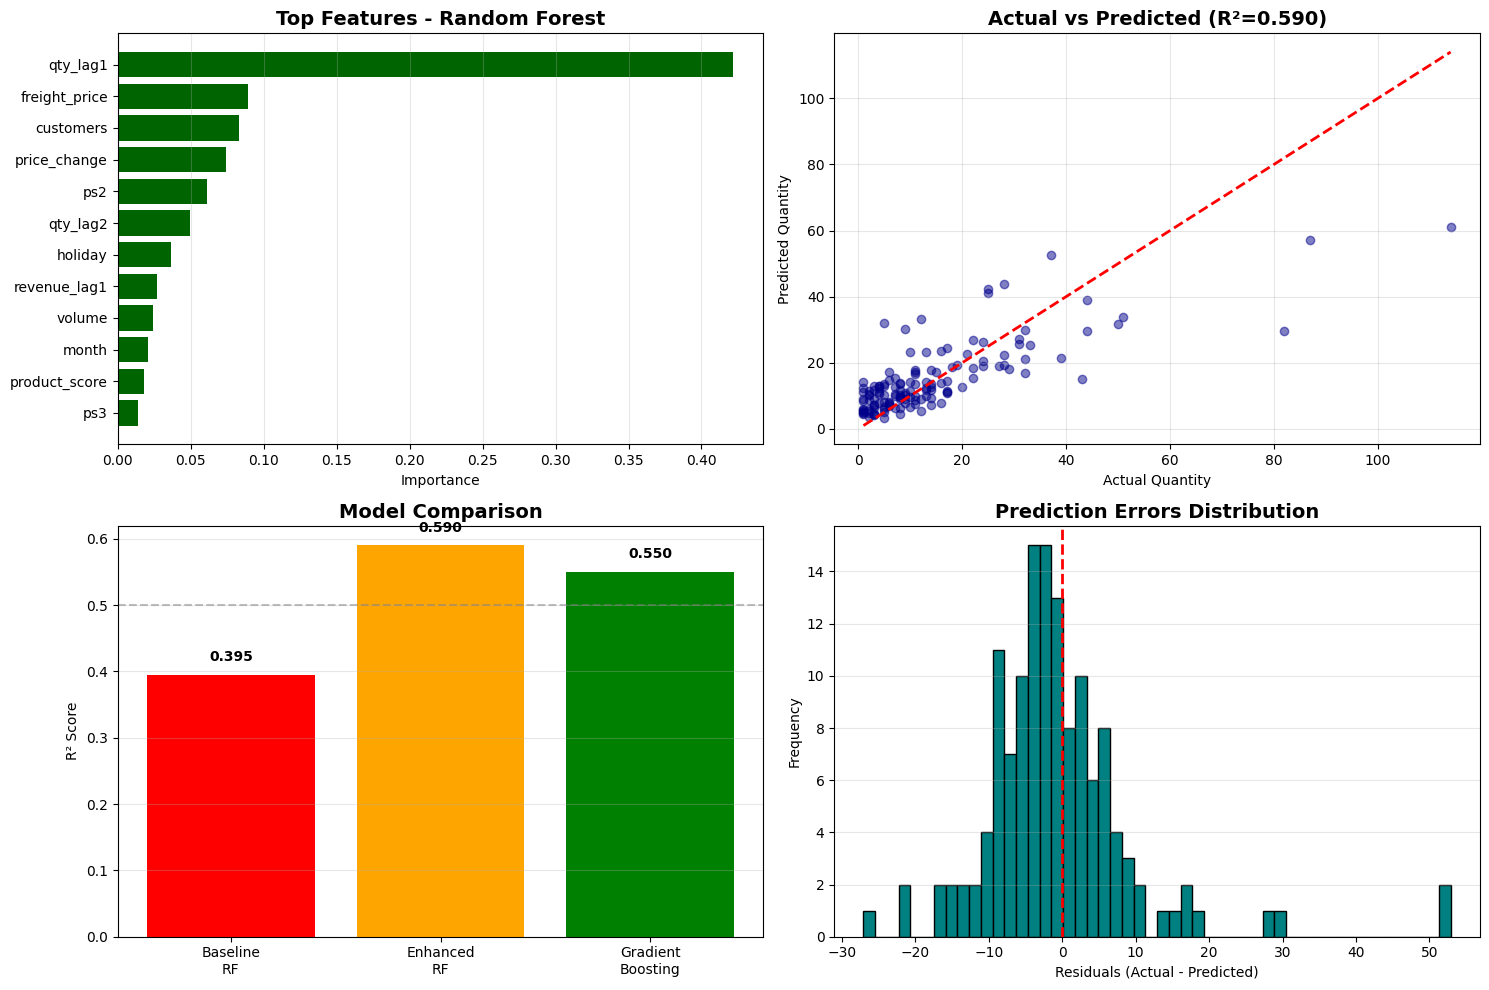


🎯 Top 10 Most Important Features:
      feature  importance
     qty_lag1    0.421387
freight_price    0.089282
    customers    0.082876
 price_change    0.074425
          ps2    0.060974
     qty_lag2    0.049621
      holiday    0.036854
 revenue_lag1    0.026875
       volume    0.024240
        month    0.020700


In [12]:
# ===== PART 5B: IMPROVED DEMAND FORECASTING MODEL =====

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

# Create additional features
df['price_change'] = df.groupby('product_id')['unit_price'].diff()
df['qty_lag1'] = df.groupby('product_id')['qty'].shift(1)
df['qty_lag2'] = df.groupby('product_id')['qty'].shift(2)
df['revenue_lag1'] = df.groupby('product_id')['revenue'].shift(1)
df['price_position_score'] = df['unit_price'] / df['avg_competitor_price']
df['quarter'] = df['month_year'].dt.quarter

# Enhanced feature set
feature_cols_enhanced = ['unit_price', 'freight_price', 'product_score', 'customers',
                        'weekend', 'holiday', 'month', 'year', 'volume', 'quarter',
                        'ps1', 'ps2', 'ps3', 'lag_price',
                        'price_vs_comp1', 'price_vs_comp2', 'price_vs_comp3',
                        'avg_competitor_price', 'price_difference', 'is_cheapest',
                        'price_change', 'qty_lag1', 'qty_lag2', 'revenue_lag1',
                        'price_position_score']

X_enhanced = df[feature_cols_enhanced].fillna(0)
y = df['qty']

# Convert boolean to int
X_enhanced['is_cheapest'] = X_enhanced['is_cheapest'].astype(int)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_enhanced, y, test_size=0.2, random_state=42)

print("=" * 60)
print("TRAINING ENHANCED MODELS")
print("=" * 60)

# Model 1: Improved Random Forest
print("\n1. Training Enhanced Random Forest...")
rf_enhanced = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf_enhanced.fit(X_train, y_train)
y_pred_rf = rf_enhanced.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"   MAE: {mae_rf:.2f}")
print(f"   RMSE: {rmse_rf:.2f}")
print(f"   R² Score: {r2_rf:.3f}")

# Model 2: Gradient Boosting
print("\n2. Training Gradient Boosting Model...")
gb_model = GradientBoostingRegressor(
    n_estimators=200,
    max_depth=7,
    learning_rate=0.1,
    random_state=42
)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)

mae_gb = mean_absolute_error(y_test, y_pred_gb)
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
r2_gb = r2_score(y_test, y_pred_gb)

print(f"   MAE: {mae_gb:.2f}")
print(f"   RMSE: {rmse_gb:.2f}")
print(f"   R² Score: {r2_gb:.3f}")

# Choose best model
if r2_gb > r2_rf:
    best_model = gb_model
    best_pred = y_pred_gb
    best_r2 = r2_gb
    best_mae = mae_gb
    best_name = "Gradient Boosting"
    feature_importance = pd.DataFrame({
        'feature': feature_cols_enhanced,
        'importance': gb_model.feature_importances_
    }).sort_values('importance', ascending=False)
else:
    best_model = rf_enhanced
    best_pred = y_pred_rf
    best_r2 = r2_rf
    best_mae = mae_rf
    best_name = "Random Forest"
    feature_importance = pd.DataFrame({
        'feature': feature_cols_enhanced,
        'importance': rf_enhanced.feature_importances_
    }).sort_values('importance', ascending=False)

print("\n" + "=" * 60)
print(f"BEST MODEL: {best_name}")
print("=" * 60)
print(f"R² Score: {best_r2:.3f} ({best_r2*100:.1f}% variance explained)")
print(f"Mean Absolute Error: {best_mae:.2f} units")
print(f"Improvement from baseline: {((best_r2 - 0.395) / 0.395 * 100):.1f}%")
print("=" * 60)

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Feature importance
top_features = feature_importance.head(12)
axes[0,0].barh(top_features['feature'], top_features['importance'], color='darkgreen')
axes[0,0].set_xlabel('Importance')
axes[0,0].set_title(f'Top Features - {best_name}', fontsize=14, fontweight='bold')
axes[0,0].invert_yaxis()
axes[0,0].grid(True, alpha=0.3, axis='x')

# Actual vs Predicted
axes[0,1].scatter(y_test, best_pred, alpha=0.5, color='darkblue')
axes[0,1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
axes[0,1].set_xlabel('Actual Quantity')
axes[0,1].set_ylabel('Predicted Quantity')
axes[0,1].set_title(f'Actual vs Predicted (R²={best_r2:.3f})', fontsize=14, fontweight='bold')
axes[0,1].grid(True, alpha=0.3)

# Model comparison
models = ['Baseline\nRF', 'Enhanced\nRF', 'Gradient\nBoosting']
scores = [0.395, r2_rf, r2_gb]
colors = ['red', 'orange', 'green']
axes[1,0].bar(models, scores, color=colors)
axes[1,0].set_ylabel('R² Score')
axes[1,0].set_title('Model Comparison', fontsize=14, fontweight='bold')
axes[1,0].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
axes[1,0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(scores):
    axes[1,0].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

# Residuals distribution
residuals = y_test - best_pred
axes[1,1].hist(residuals, bins=50, edgecolor='black', color='teal')
axes[1,1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[1,1].set_xlabel('Residuals (Actual - Predicted)')
axes[1,1].set_ylabel('Frequency')
axes[1,1].set_title('Prediction Errors Distribution', fontsize=14, fontweight='bold')
axes[1,1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n🎯 Top 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

# Store the best model for next part
rf_model = best_model

DYNAMIC PRICING RECOMMENDATIONS

Product: bed1 | Category: bed_bath_table
Current Price: $39.24
Recommended Optimal Price: $51.01 (+30.0%)
Current Revenue: $313.92
Projected Revenue: $370.44 (+18.0%)
Expected Quantity: 7 units


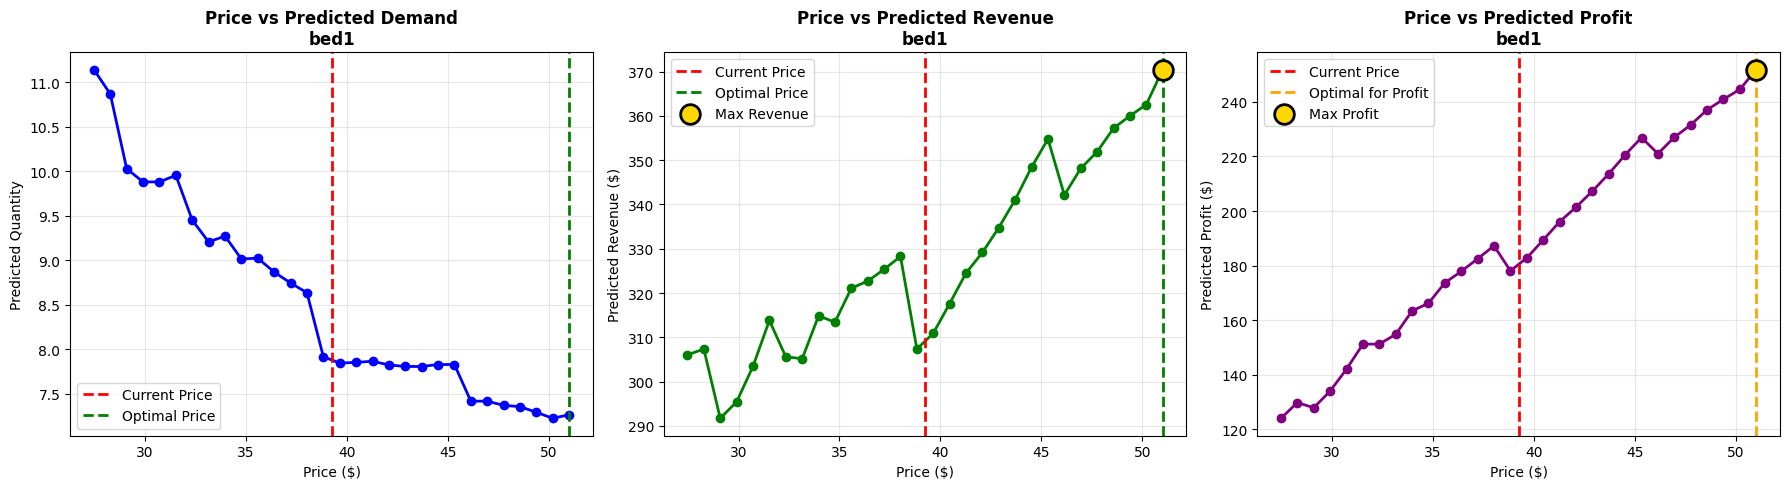


Product: garden5 | Category: garden_tools
Current Price: $101.00
Recommended Optimal Price: $131.30 (+30.0%)
Current Revenue: $101.00
Projected Revenue: $613.04 (+507.0%)
Expected Quantity: 5 units


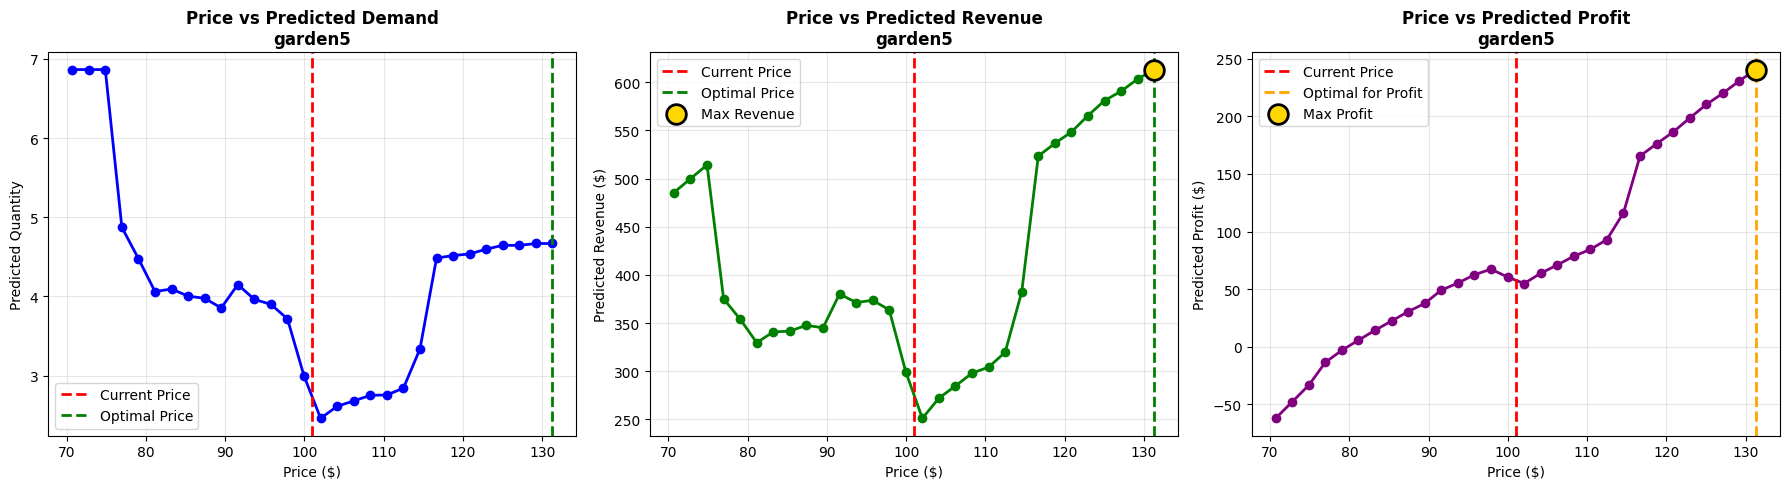


Product: consoles1 | Category: consoles_games
Current Price: $36.20
Recommended Optimal Price: $28.34 (-21.7%)
Current Revenue: $36.20
Projected Revenue: $243.22 (+571.9%)
Expected Quantity: 9 units


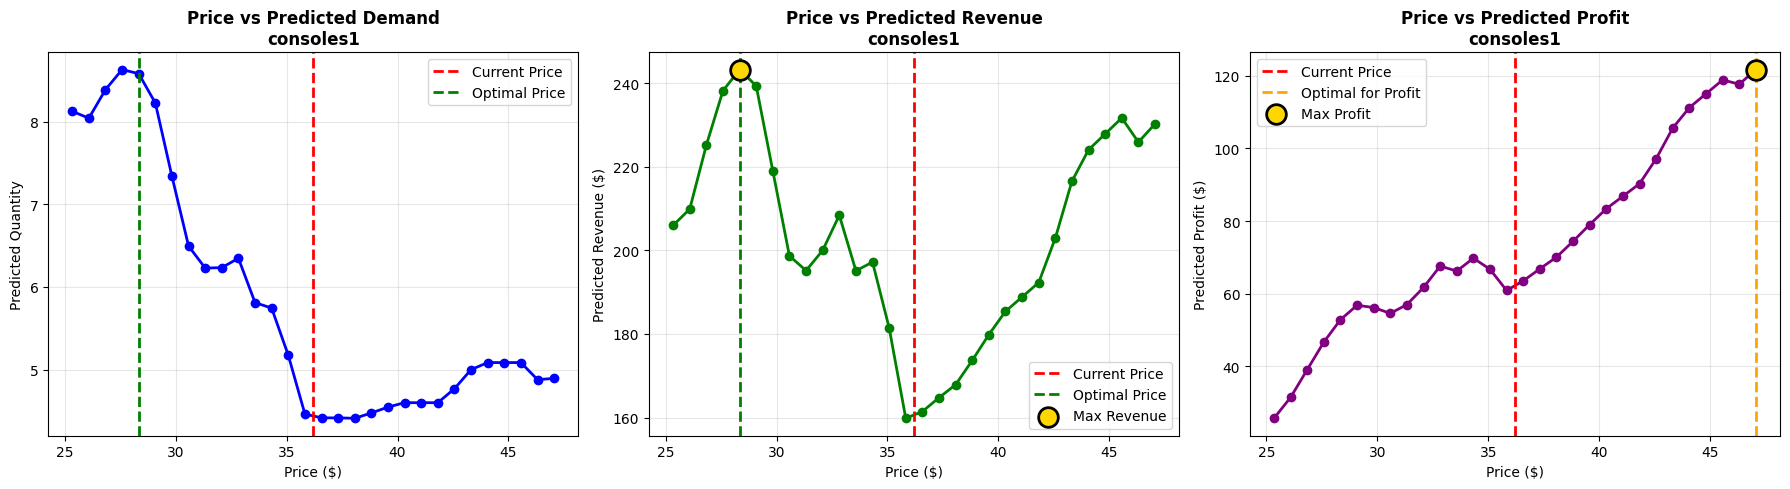


Product: garden7 | Category: garden_tools
Current Price: $49.90
Recommended Optimal Price: $64.87 (+30.0%)
Current Revenue: $349.30
Projected Revenue: $548.17 (+56.9%)
Expected Quantity: 8 units


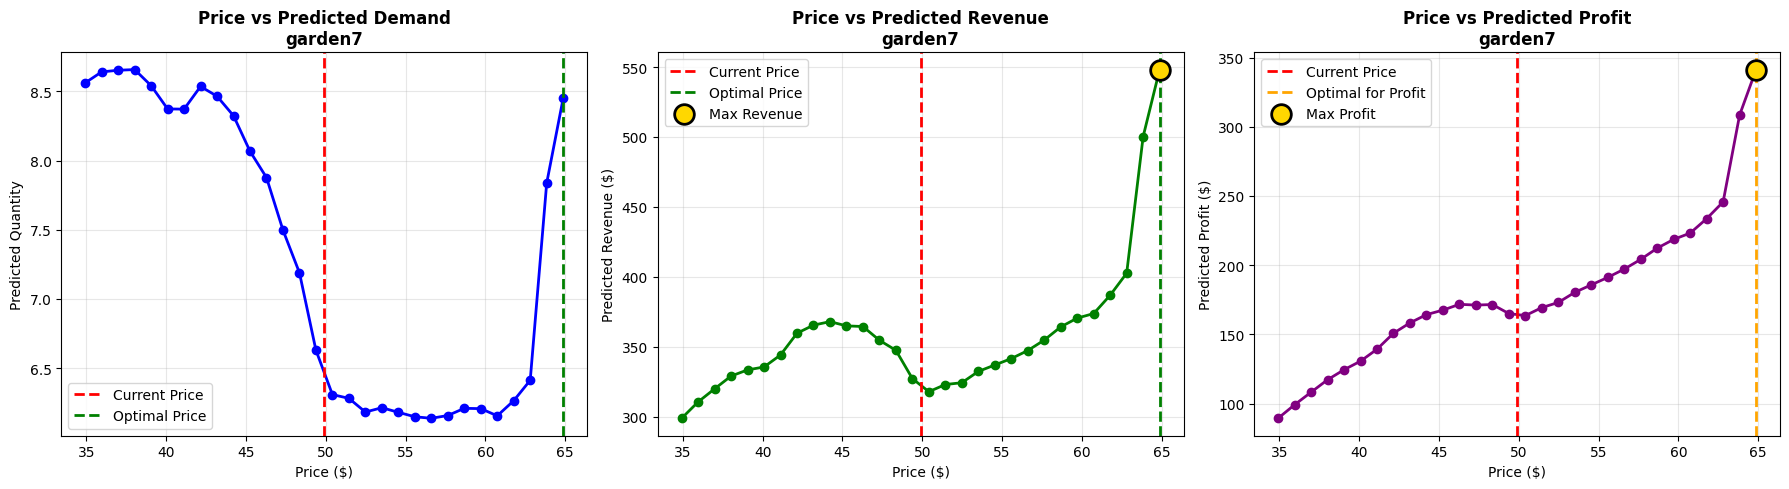


Product: health9 | Category: health_beauty
Current Price: $23.99
Recommended Optimal Price: $28.21 (+17.6%)
Current Revenue: $47.98
Projected Revenue: $171.55 (+257.5%)
Expected Quantity: 6 units


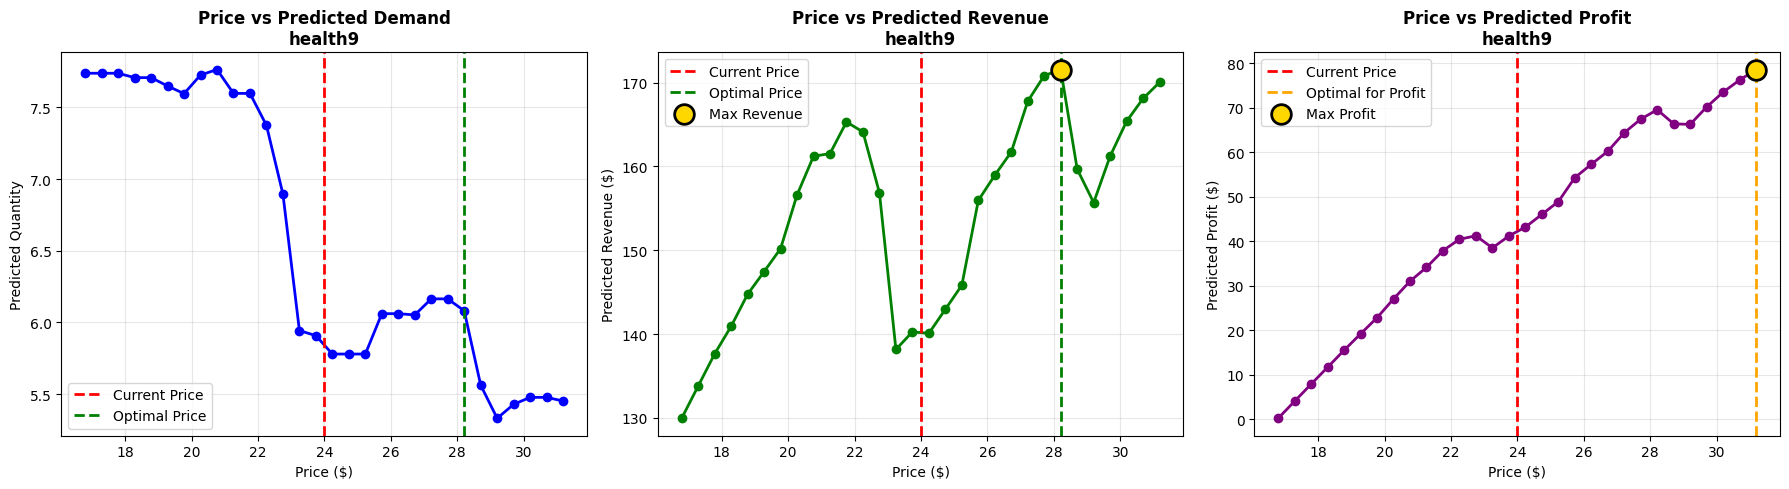


PRICING RECOMMENDATIONS SUMMARY
product_id       category  current_price  optimal_price  price_change_%  current_revenue  projected_revenue  revenue_increase_%
      bed1 bed_bath_table          39.24      51.012000       30.000000           313.92         370.444580           18.006046
   garden5   garden_tools         101.00     131.300000       30.000000           101.00         613.043155          506.973421
 consoles1 consoles_games          36.20      28.335862      -21.724138            36.20         243.220620          571.880165
   garden7   garden_tools          49.90      64.870000       30.000000           349.30         548.166961           56.932998
   health9  health_beauty          23.99      28.208931       17.586207            47.98         171.545564          257.535566

OVERALL IMPACT
Total Current Revenue: $848.40
Total Projected Revenue: $1,946.42
Expected Revenue Increase: +129.4%
Additional Revenue: $1,098.02


In [13]:
# ===== PART 6: OPTIMAL PRICE RECOMMENDATION SYSTEM =====

def recommend_optimal_price(product_data, model, feature_cols):
    """
    Recommends optimal price by testing different price points
    """
    current_price = product_data['unit_price'].iloc[0]
    price_range = np.linspace(current_price * 0.7, current_price * 1.3, 30)

    results = []
    for test_price in price_range:
        # Create test scenario
        test_data = product_data.copy()
        test_data['unit_price'] = test_price
        test_data['price_vs_comp1'] = test_price / test_data['ps1']
        test_data['price_vs_comp2'] = test_price / test_data['ps2']
        test_data['price_vs_comp3'] = test_price / test_data['ps3']
        test_data['avg_competitor_price'] = (test_data['ps1'] + test_data['ps2'] + test_data['ps3']) / 3
        test_data['price_difference'] = test_price - test_data['avg_competitor_price']
        test_data['is_cheapest'] = int((test_price < test_data['ps1'].iloc[0]) &
                                       (test_price < test_data['ps2'].iloc[0]) &
                                       (test_price < test_data['ps3'].iloc[0]))
        test_data['price_position_score'] = test_price / test_data['avg_competitor_price']
        test_data['price_change'] = test_price - current_price

        # Predict demand
        X_test = test_data[feature_cols].fillna(0)
        predicted_qty = max(0, model.predict(X_test)[0])  # Ensure non-negative
        predicted_revenue = test_price * predicted_qty
        predicted_profit = (test_price - test_data['freight_price'].iloc[0]) * predicted_qty

        results.append({
            'price': test_price,
            'predicted_qty': predicted_qty,
            'predicted_revenue': predicted_revenue,
            'predicted_profit': predicted_profit
        })

    results_df = pd.DataFrame(results)
    optimal_revenue_row = results_df.loc[results_df['predicted_revenue'].idxmax()]
    optimal_profit_row = results_df.loc[results_df['predicted_profit'].idxmax()]

    return results_df, optimal_revenue_row, optimal_profit_row

# Test on multiple products
print("=" * 80)
print("DYNAMIC PRICING RECOMMENDATIONS")
print("=" * 80)

# Get unique products
unique_products = df['product_id'].unique()[:5]  # Test on first 5 products

recommendations = []

for product in unique_products:
    product_data = df[df['product_id'] == product].iloc[-1:].copy()

    price_scenarios, optimal_revenue, optimal_profit = recommend_optimal_price(
        product_data, best_model, feature_cols_enhanced
    )

    current_price = product_data['unit_price'].iloc[0]
    current_qty = product_data['qty'].iloc[0]
    current_revenue = product_data['revenue'].iloc[0]

    revenue_increase = ((optimal_revenue['predicted_revenue'] - current_revenue) / current_revenue * 100)
    price_change_pct = ((optimal_revenue['price'] - current_price) / current_price * 100)

    recommendations.append({
        'product_id': product,
        'category': product_data['product_category_name'].iloc[0],
        'current_price': current_price,
        'optimal_price': optimal_revenue['price'],
        'price_change_%': price_change_pct,
        'current_revenue': current_revenue,
        'projected_revenue': optimal_revenue['predicted_revenue'],
        'revenue_increase_%': revenue_increase
    })

    print(f"\n{'='*80}")
    print(f"Product: {product} | Category: {product_data['product_category_name'].iloc[0]}")
    print(f"{'='*80}")
    print(f"Current Price: ${current_price:.2f}")
    print(f"Recommended Optimal Price: ${optimal_revenue['price']:.2f} ({price_change_pct:+.1f}%)")
    print(f"Current Revenue: ${current_revenue:.2f}")
    print(f"Projected Revenue: ${optimal_revenue['predicted_revenue']:.2f} ({revenue_increase:+.1f}%)")
    print(f"Expected Quantity: {optimal_revenue['predicted_qty']:.0f} units")

    # Visualize price optimization for this product
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Price vs Demand
    axes[0].plot(price_scenarios['price'], price_scenarios['predicted_qty'],
                marker='o', linewidth=2, color='blue')
    axes[0].axvline(current_price, color='red', linestyle='--', linewidth=2, label='Current Price')
    axes[0].axvline(optimal_revenue['price'], color='green', linestyle='--', linewidth=2, label='Optimal Price')
    axes[0].set_title(f'Price vs Predicted Demand\n{product}', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Price ($)')
    axes[0].set_ylabel('Predicted Quantity')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Price vs Revenue
    axes[1].plot(price_scenarios['price'], price_scenarios['predicted_revenue'],
                marker='o', linewidth=2, color='green')
    axes[1].axvline(current_price, color='red', linestyle='--', linewidth=2, label='Current Price')
    axes[1].axvline(optimal_revenue['price'], color='green', linestyle='--', linewidth=2, label='Optimal Price')
    axes[1].scatter(optimal_revenue['price'], optimal_revenue['predicted_revenue'],
                   s=200, color='gold', edgecolor='black', linewidth=2, zorder=5, label='Max Revenue')
    axes[1].set_title(f'Price vs Predicted Revenue\n{product}', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Price ($)')
    axes[1].set_ylabel('Predicted Revenue ($)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # Price vs Profit
    axes[2].plot(price_scenarios['price'], price_scenarios['predicted_profit'],
                marker='o', linewidth=2, color='purple')
    axes[2].axvline(current_price, color='red', linestyle='--', linewidth=2, label='Current Price')
    axes[2].axvline(optimal_profit['price'], color='orange', linestyle='--', linewidth=2, label='Optimal for Profit')
    axes[2].scatter(optimal_profit['price'], optimal_profit['predicted_profit'],
                   s=200, color='gold', edgecolor='black', linewidth=2, zorder=5, label='Max Profit')
    axes[2].set_title(f'Price vs Predicted Profit\n{product}', fontsize=12, fontweight='bold')
    axes[2].set_xlabel('Price ($)')
    axes[2].set_ylabel('Predicted Profit ($)')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Summary table
recommendations_df = pd.DataFrame(recommendations)
print("\n" + "=" * 80)
print("PRICING RECOMMENDATIONS SUMMARY")
print("=" * 80)
print(recommendations_df.to_string(index=False))

total_current_revenue = recommendations_df['current_revenue'].sum()
total_projected_revenue = recommendations_df['projected_revenue'].sum()
total_increase = ((total_projected_revenue - total_current_revenue) / total_current_revenue * 100)

print("\n" + "=" * 80)
print("OVERALL IMPACT")
print("=" * 80)
print(f"Total Current Revenue: ${total_current_revenue:,.2f}")
print(f"Total Projected Revenue: ${total_projected_revenue:,.2f}")
print(f"Expected Revenue Increase: {total_increase:+.1f}%")
print(f"Additional Revenue: ${(total_projected_revenue - total_current_revenue):,.2f}")
print("=" * 80)